In [ ]:
#Campeonato Quantamental
#Pegando dados P/L
import requests
import pandas as pd
import io
import json
import re
import pandas as pd
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data, wb
import numpy as np
from datetime import *
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import sys

headers = {
    'authority': 'www.oceans14.com.br',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Mobile Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    # coloque aqui a url de qualquer canto que seja do site oceans14
    'referer': 'https://www.oceans14.com.br/acoes/engie/egie3/balanco-dividendos',
    'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7,la;q=0.6',
    'cookie': 'ASP.NET_SessionId=jypd15qvl1yu3ypbgqzecxjj; uid=0EAB27F50DB06E1775959795C4949E2D; origem=https://l.facebook.com/; contadorViewsAcoes=3',
}

params = (
    ######IDENTIFICAR TICKER DA ACAO######
    ('papel', 'EGIE3'),
    ('periodo', '10a'),
)

response = requests.get('https://www.oceans14.com.br/rendaVariavel/respostaAjax/gHistoricoPl.aspx', headers=headers, params=params)
dframe = pd.json_normalize(response.json())
jason = response.text
normal = json.loads(jason)
datas = []
valores = []
for row in normal["rows"]:
    date = row['c'][0]['v']
    formatedDate = re.search(r"(?<=Date\()[^\):]+(?=:?\))", date).group(0)
    simpleData = formatedDate.replace(',', '-').replace(' ', '')
    separatedData = simpleData.split('-')
    correctDataList = ''
    for number in separatedData:
        if number != '0':
            correctDataList += ("%02d" % int(number)) + "-"
    correctDataList = correctDataList[:-1]
    datas.append(correctDataList)
    valores.append(row['c'][1]['v'])
frameDict = {
    "Date": datas,
    "valores": valores
}
dframe = pd.DataFrame(data=frameDict)
dframe['valores'] = dframe['valores'].values.tolist()
dframe['valores'] = valores
dframe

,Date,valores
0,2010-06-19,12.62
1,2010-06-20,12.56
2,2010-06-21,12.68
3,2010-06-22,13.10
4,2010-06-23,12.86
...,...,...
2464,2020-06-07,15.86
2465,2020-06-08,15.72
2466,2020-06-09,15.64
2467,2020-06-10,15.52


In [ ]:
#tickers = ['ITUB3.SA'] #IDENTIFICAR TICKER DA ACAO######
acao = 'EGIE3'
start_date = '2010-07-02'
end_date = '2020-06-24'
df = data.DataReader('EGIE3.SA', 'yahoo', start_date, end_date) #digitar ticker
df['Preco_Lucro'] = valores
tabela = df[['Close', 'Preco_Lucro']]

#tabela.set_index('Date',inplace=True)
#tabela


In [ ]:
upperband, middleband, lowerband = talib.BBANDS(tabela['Preco_Lucro'], timeperiod=200, nbdevup=2, nbdevdn=2, matype=0)
tabela['upperband'] = upperband
tabela['middleband'] = middleband
tabela['lowerband'] = lowerband


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
tabela = tabela.dropna()
#tabela.set_index('Date',inplace=True)

In [ ]:
ibov = data.DataReader('^BVSP', 'yahoo', '2011-04-08', '2020-06-17')

In [ ]:
#Logico

def buy_sell(tabela): 
    compras = []
    vendas = []
    #tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######
    flag = 3
    #flag = 1 comprado
    #flag = 0 vendeu
    
    for i in range(len(tabela)):
        ###Testa se é para Comprar
        if tabela['Preco_Lucro'][i] < tabela['lowerband'][i]:   
          if flag != 1:
            compras.append(tabela['Close'][i])
            vendas.append(np.nan)
            flag = 1
          else:
            compras.append(np.nan)
            vendas.append(np.nan)
        ###Testa se é para Vender
        elif (tabela['Preco_Lucro'][i] > tabela['upperband'][i]):
          if ((flag != 0) & (flag != 3)):
            compras.append(np.nan)
            vendas.append(tabela['Close'][i])
            flag = 0
          else:
            compras.append(np.nan)
            vendas.append(np.nan)
        ###Caso nem compre nem vende
        else:
          compras.append(np.nan)
          vendas.append(np.nan)
        
    return (compras, vendas)



In [ ]:
compras,vendas = buy_sell(tabela)
tabela['compra'] = compras
tabela['venda'] = vendas
tabela
#compras

,Close,Preco_Lucro,upperband,middleband,lowerband,compra,venda
Date,,,,,,,
2011-04-27,22.591999,14.11,15.245512,14.03820,12.830888,NaN,NaN
2011-04-28,22.320000,14.08,15.235962,14.04550,12.855038,NaN,NaN
2011-04-29,22.048000,14.06,15.224684,14.05300,12.881316,NaN,NaN
2011-05-02,22.000000,13.78,15.214576,14.05850,12.902424,NaN,NaN
2011-05-03,21.760000,13.94,15.210893,14.06270,12.914507,NaN,NaN
...,...,...,...,...,...,...,...
2020-06-18,43.599998,15.86,19.265850,15.89600,12.526150,NaN,NaN
2020-06-19,43.250000,15.72,19.260333,15.89175,12.523167,NaN,NaN
2020-06-22,43.709999,15.64,19.256185,15.88810,12.520015,NaN,NaN


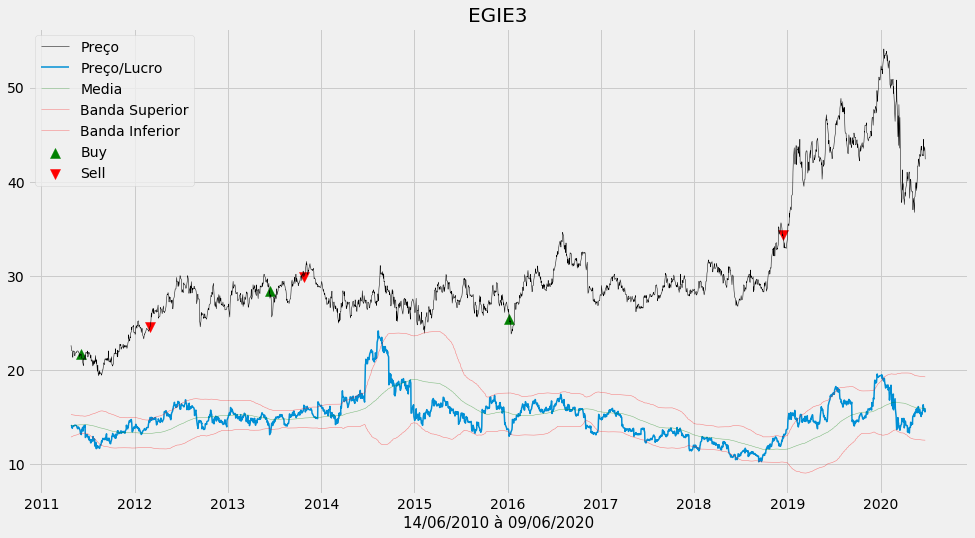

In [ ]:
#tickers = 'AAPL' ######IDENTIFICAR TICKER DA ACAO######
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))
plt.plot(tabela['Close'], label = 'Preço',alpha = 1, linewidth=0.5, color='black')
plt.plot(tabela['Preco_Lucro'], label = 'Preço/Lucro', alpha = 1, linewidth=1.5)
plt.plot(tabela['middleband'], label = 'Media',alpha = 0.5, linewidth=0.5, color='green')
plt.plot(tabela['upperband'], label = 'Banda Superior',alpha = 0.5, linewidth=0.5, color='red')
plt.plot(tabela['lowerband'], label = 'Banda Inferior',alpha = 0.5, linewidth=0.5, color='red')
plt.scatter(tabela.index, tabela['compra'], label = 'Buy', marker='^',color = 'green', s=100)
plt.scatter(tabela.index, tabela['venda'], label = 'Sell',marker="v",color = 'red', s=100)
plt.xlabel('14/06/2010 à 09/06/2020', fontsize =15)
plt.title(acao, fontsize=20)
plt.legend(loc='best')

In [ ]:
#Puxando valores do CDI


def consulta_bc(codigo_bcb):
    urls = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    cdi = pd.read_json(urls)
    cdi['data'] = pd.to_datetime(cdi['data'])
    cdi.set_index('data', inplace=True)
    data_inicio = '2011-04-15'
    cdi = (cdi[cdi.index >= data_inicio])
    return cdi

cdi = consulta_bc(12)
cdi

,valor
data,
2011-05-01,0.040132
2011-06-01,0.040132
2011-07-01,0.040132
2011-10-01,0.040132
2011-11-01,0.040132
...,...
2020-07-07,0.008442
2020-08-07,0.008442
2020-09-07,0.008442


In [ ]:
def backtest_strategy(tabela, capital, benchmark): #volatility_threshold vai ajudar a definir o que é uma volatilidade baixa
    
                #pega na tabela price[simbolo] =0 e tbm coloca uma coluna cash
    df_init   = (tabela['Close']*0).to_frame().assign(cash = 0)#lida com a posicao no inicio do dia
    df_update = (tabela['Close']*0).to_frame().assign(cash = 0)#lida com as mudanças de posicao durante o dia
    df_end    = (tabela['Close']*0).to_frame().assign(cash = 0)#lida com a posicao no fim do dia
    
    df_init.iloc[0, df_init.columns.get_loc('cash')] = capital#colocando capital incial na primeira linha do data frameINICIAL
    df_end.iloc[0, df_end.columns.get_loc('cash')]   = capital#colocando capital incial na primeira linha do data frameFINAL dia
    
    calendar = pd.Series(tabela.index).iloc[1:]#pulando primeiro dia, que a gente nao faz trading e pegando todos od dias
    
    Numero_acoes_anterior=0
    Quantidade_em_caixa_anterior=capital
    for date in calendar:
        prev_date = df_init.index[df_init.index<date][-1]#p/ saber qual é o dia anterior
        
        df_init.loc[date, :] = df_end.loc[prev_date, :]#fazendo inicio dia ser igual ao final dia do DiaAnterior
        
        port_value = df_init.loc[date, 'Close'] * tabela.loc[date, 'Close'] + df_init.loc[date, 'cash']#valor do portifolio no inicio do dia= posiciao inicio dia*preço + valor em caixa
        
        #fazendo a trasicao entre caixa e comprado
        
        if tabela.loc[date, 'Preco_Lucro'] > tabela.loc[date, 'upperband']: # volatility is high -> be fully in cash
            df_end.loc[date, 'Close']=0
            Numero_acoes_anterior = 0
            df_end.loc[date, 'cash'] = port_value
            Quantidade_em_caixa_anterior = port_value
        elif (tabela.loc[date, 'Preco_Lucro'] < tabela.loc[date,'lowerband']): # volatility is low -> be in market position
            df_end.loc[date, 'Close'] = port_value/tabela.loc[date, 'Close']
            Numero_acoes_anterior = port_value/tabela.loc[date, 'Close']#divide pelo preco p colocar so a qtd alocada e n o valor
            df_end.loc[date, 'cash']=0
            Quantidade_em_caixa_anterior = 0
        else:
            df_end.loc[date, 'Close'] = Numero_acoes_anterior
            df_end.loc[date, 'cash'] = Quantidade_em_caixa_anterior
            
        df_update.loc[date] = df_end.loc[date] - df_init.loc[date]#passando a diferencao p o dfUpdate
    
    #comparação com benchmark
    #portval = pd.DataFrame()                  
    portval= (df_end * tabela.assign(cash = 1)[['Close', 'cash']]).sum(axis = 1).to_frame().rename(columns = {0:'strategy'})#trocando qdt alocada pelo valor alocado e juntando as duas colunas- para dar uma coluna com o valor final de cada dia (strategy) 
    portval['benchmark'] = benchmark['Close']
    portval[acao] = tabela['Close']
    portval = (portval/portval.iloc[0].values) #normalizando o valor inicial
    
    return (portval)


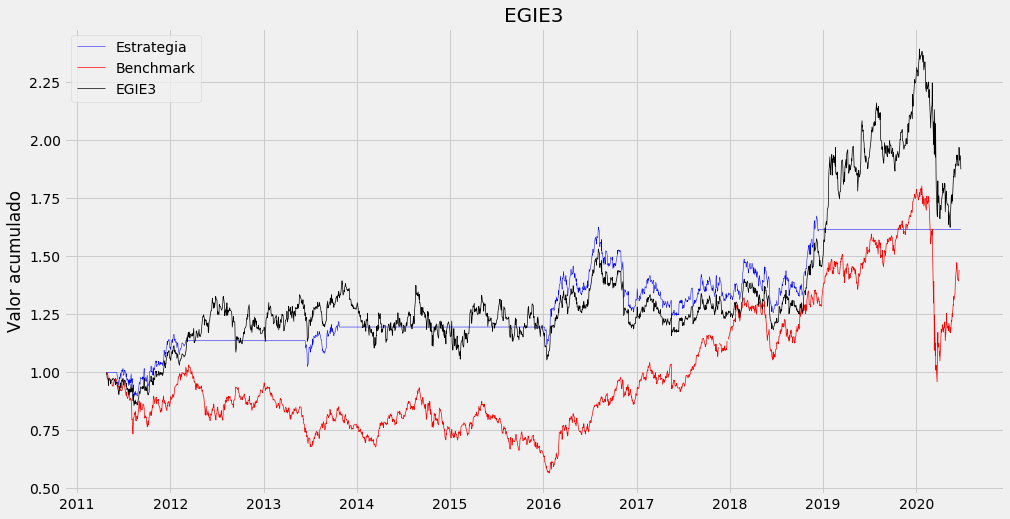

In [ ]:
#atribui uma tabela para as novas informacoes da carteira
res = backtest_strategy(tabela = tabela, capital = 10000, benchmark = ibov)

#plota tabela res
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))
plt.plot(res['strategy'], label = 'Estrategia',alpha = 1, linewidth=0.5, color='blue')
plt.plot(res['benchmark'], label = 'Benchmark',alpha = 1, linewidth=0.7, color='red')
plt.plot(res[acao], label = acao,alpha = 1, linewidth=0.7, color='black')
#adicionar um subplot
plt.ylabel('Valor acumulado')
plt.title(acao, fontsize=20)
plt.legend(loc='best')

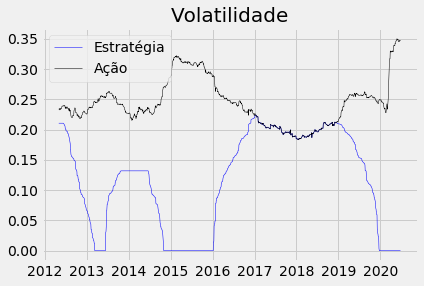

In [ ]:
#CALCULANDO VOLATILIDADE DA CARTEIRA

carteira = res['strategy']
# calculando retorno log
res['Log_strategy'] = np.log(res['strategy'] / res['strategy'].shift(1))
res['Log_acao'] = np.log(res[acao] / res[acao].shift(1))
# calculando volatilidade
res['Estrategia Vol'] = res['Log_strategy'].rolling(window=252).std() * np.sqrt(252)
res['Acao Vol'] = res['Log_acao'].rolling(window=252).std() * np.sqrt(252)
# Plot the NIFTY Price series and the Volatility
#volatility_estrategia = res[['Estrategia Vol']]
volatility_acao = res[['Acao Vol']]
volatility_estrategia = res[['Estrategia Vol']]

plt.plot(volatility_estrategia, label = 'Estratégia',alpha = 1, linewidth=0.5, color='blue')
plt.plot(volatility_acao, label = 'Ação',alpha = 1, linewidth=0.5, color='black')
plt.title('Volatilidade', fontsize=20)
plt.legend(loc='best')

In [ ]:
#Calculo Indice Sharpe
retorno_estrategia = res['strategy'].pct_change()
retorno_benchmark = res['benchmark'].pct_change()
#Indice sharpe estrategia
sr_estrategia = retorno_estrategia.mean()/retorno_estrategia.std()
sr_est = (252**0.5) * sr_estrategia
#Indice sharpe benchmark
st_benchmark = retorno_benchmark.mean()/retorno_benchmark.std()
sr_bench = (252**0.5) * st_benchmark

In [ ]:
#Calculo Maximo Drowdown%
#DD estrategia
drowdown_estrategia = (res['strategy'].min() - 1)*100
print('O Drowdown da sua estrategia foi {:.2f}%'.format(drowdown_estrategia))

#DD benchmark
drowdown_benchmark = (res['benchmark'].min() - 1)*100
print('O Drowdown do Benchmark foi {:.2f}%'.format(drowdown_benchmark))
#####Volatilidade#####
volatility_estrategia
volatility_acao,

O Drowdown da sua estrategia foi -10.54%
O Drowdown do Benchmark foi -43.41%


(            Acao Vol
 Date                
 2011-04-27       NaN
 2011-04-28       NaN
 2011-04-29       NaN
 2011-05-02       NaN
 2011-05-03       NaN
 ...              ...
 2020-06-18  0.347537
 2020-06-19  0.346975
 2020-06-22  0.347024
 2020-06-23  0.346740
 2020-06-24  0.347090
 
 [2270 rows x 1 columns],)

In [ ]:
#calculo do retorno estrategia
retorno_estrategia = 100 * (res['strategy'][-1]/res['strategy'][0]-1)
print('Retorno da estrategia foi {:.2f}%'.format(retorno_estrategia))
#calculo retorno benchmark
retorno_benchmark = 100 * (ibov['Close'][-1]/ibov['Close'][0]-1)
print('Retorno do benchmark foi {:.2f}%'.format(retorno_benchmark))

Retorno da estrategia foi 61.53%
Retorno do benchmark foi 39.04%


In [ ]:
resultados = pd.DataFrame([['Retorno', retorno_estrategia, retorno_benchmark],
                           ['Sharpe Ratio', sr_est, sr_bench],
                           ['Drowdown', drowdown_estrategia, drowdown_benchmark],
                           ['Volatilidade', volatility_estrategia.mean(), volatility_acao.mean()]],
                          columns=['Indice', 'Estrategia', 'Benchmark']) 
resultados

,Indice,Estrategia,Benchmark
0,Retorno,61.533,39.0422
1,Sharpe Ratio,0.440689,0.287291
2,Drowdown,-10.536,-43.4127
3,Volatilidade,Estrategia Vol 0.117566 dtype: float64,Acao Vol 0.243682 dtype: float64
